In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
from jax import vmap
import tqdm
import numpy as np
from scipy.linalg import eig

In [ ]:
jax.config.update("jax_enable_x64", True)

In [ ]:
#Define 2D Gaussian kernel and derivatives
def kernel(s1,t1,s2,t2,sigma1,sigma2):
  K = jnp.exp(-((s1-t1)**2/(2*sigma1**2))-((s2-t2)**2/(2*sigma2**2)))
  #r = jnp.sqrt((s1-t1)**2/sigma1**2+(s2-t2)**2/sigma2**2)
  #K = (1+jnp.sqrt(5)*(r)+5/3*r**2)*jnp.exp(-jnp.sqrt(5)*r)
  #K = (s1*t1+s2*t2+sigma1)**sigma2
  return K

def kernel_dx1(s1,t1,s2,t2,sigma1,sigma2):
  #r = jnp.sqrt((s1-t1)**2/sigma1**2+(s2-t2)**2/sigma2**2)
  #K = jnp.exp(-jnp.sqrt(5)*r)*(-5/(3*sigma1**2)*(s1-t1)-5*jnp.sqrt(5)*(s1-t1)/(3*sigma1**2))
  return -(s1-t1)*kernel(s1,t1,s2,t2,sigma1,sigma2)/(sigma1**2)

def kernel_dy1(s1,t1,s2,t2,sigma1,sigma2):
  return -kernel_dx1(s1,t1,s2,t2,sigma1,sigma2)
  #-(t1-s1)*kernel(s1,t1,s2,t2,sigma1,sigma2)/(sigma1**2)

def kernel_dx2(s1,t1,s2,t2,sigma1,sigma2):
  #r = jnp.sqrt((s1-t1)**2/sigma1**2+(s2-t2)**2/sigma2**2)
  #K = jnp.exp(-jnp.sqrt(5)*r)*(-5/(3*sigma2**2)*(s2-t2)-5*jnp.sqrt(5)*(s2-t2)/(3*sigma2**2))
  return -(s2-t2)*kernel(s1,t1,s2,t2,sigma1,sigma2)/(sigma2**2)

def kernel_dy2(s1,t1,s2,t2,sigma1,sigma2):
  return -kernel_dx2(s1,t1,s2,t2,sigma1,sigma2)
  #-(t2-s2)*kernel(s1,t1,s2,t2,sigma1,sigma2)/(sigma2**2)

def kernel_dx1dy1(s1,t1,s2,t2,sigma1,sigma2):
  #r = jnp.sqrt((s1-t1)**2/sigma1**2+(s2-t2)**2/sigma2**2)
  #K = jnp.exp(-jnp.sqrt(5)*r)*(5/(3*sigma1**2)+5*jnp.sqrt(5)/(3*sigma1**2)*r-25/(3*sigma1**4)*(s1-t1)**2)
  return (sigma1**2-(s1-t1)**2)*kernel(s1,t1,s2,t2,sigma1,sigma2)/(sigma1**4)

def kernel_dx1dy2(s1,t1,s2,t2,sigma1,sigma2):
  #r = jnp.sqrt((s1-t1)**2/sigma1**2+(s2-t2)**2/sigma2**2)
  #K = jnp.exp(-jnp.sqrt(5)*r)*(-25*(s1-t1)*(s2-t2)/(3*sigma1**2*sigma2**2))
  return (t2-s2)*(s1-t1)*kernel(s1,t1,s2,t2,sigma1,sigma2)/(sigma1**2*sigma2**2)

def kernel_dx2dy1(s1,t1,s2,t2,sigma1,sigma2):
  return kernel_dx1dy2(s1,t1,s2,t2,sigma1,sigma2)
   #(s2-t2)*(t1-s1)*kernel(s1,t1,s2,t2,sigma1,sigma2)/(sigma1**2*sigma2**2)

def kernel_dx2dy2(s1,t1,s2,t2,sigma1,sigma2):
  #r = jnp.sqrt((s1-t1)**2/sigma1**2+(s2-t2)**2/sigma2**2)
  #K = jnp.exp(-jnp.sqrt(5)*r)*(5/(3*sigma2**2)+5*jnp.sqrt(5)/(3*sigma2**2)*r-25/(3*sigma2**4)*(s2-t2)**2)
  return (sigma2**2-(s2-t2)**2)*kernel(s1,t1,s2,t2,sigma1,sigma2)/(sigma2**4)


In [ ]:
#Define Jacobian matrix E= dF(0)/dz at origin
alpha = 1
beta = -1
delta = 0.5

E = jnp.array([[0,alpha],[-beta,-delta]])

In [ ]:
V = jnp.array([[5,-0.5,2.5],[2,0.5,-0.5],[2,-0.5,0.5]])

In [ ]:
eig(V,left=True)

(array([ 5.70156212+0.j, -0.70156212+0.j,  1.        +0.j]),
 array([[ 0.88907316,  0.38872822,  0.        ],
        [-0.12771746, -0.21140892, -0.70710678],
        [ 0.43958749, -0.89677012,  0.70710678]]),
 array([[ 0.89582767,  0.24074446, -0.20751434],
        [ 0.31423938, -0.68630974, -0.96840025],
        [ 0.31423938, -0.68630974,  0.13834289]]))

In [ ]:
#Define (z_1,z_2) grid

npoints = 50
x_grid = jnp.linspace(-2, 2, npoints)
y_grid = jnp.linspace(-2, 2, npoints)

X,Y = jnp.meshgrid(x_grid,y_grid)
XY = jnp.zeros((npoints**2,2))

k = 0
for i in range(npoints):
  for j in range(npoints):
    XY = XY.at[k,:].set(jnp.array([X[i,j],Y[i,j]]))
    k = k+1

In [ ]:
#Define functions F and G
def F(x):
    value1 = x[:,1]
    value2 = -delta*x[:,1]- x[:,0]*(beta+alpha*x[:,0]**2)
    return jnp.array([value1, value2]).T

# Define the function g using autograd's numpy (jnp)
def G(x):
    value = jnp.zeros((len(x),2))
    for i in range(len(x)):
      value = value.at[i,:].set(jnp.dot(E, x[i,:]))
    value = F(x)-value
    return value


In [ ]:
#Evaluate F and G at collocation points (z_1,z_2)

F_val = F(XY)
G_val = G(XY)

In [ ]:
#Calculate eigenvalues and left eigenvectors of E

eval,evecL,evecR = eig(E,left=True)

v1 = evecL[:,0]
v2 = evecL[:,1]

In [ ]:
eval1 = eval[0]

In [ ]:
#Calculate vector Y in regression formula: Y_1 = 0 and Y_i = -G(z)^T w for i=2,...,N+1

evecLrep = np.repeat(v1,npoints**2).reshape(2,npoints**2).T

Y_train = jnp.zeros(npoints**2+3)
for i in range(npoints**2):
  Y_train = Y_train.at[i+3].set(-jnp.dot(evecLrep[i,:],G_val[i,:]))

In [ ]:
#Generate matrix K(Z,Z) , where Z=(z_1,z_2): K(Z,Z)_{ij}=K(Z_i,Z_j)= K((z_1,z_2)_i,(z_1,z_2)_j)

def K_Anisotropic(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

In [ ]:
#Derivatives of K(Z,Z) with respects to x_1,x_2,y_1,y_2

def K_Anisotropic_dx1(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_dx1(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())
  #val = vmap(lambda s1, t1, s2, t2: grad(kernel,0)(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

def K_Anisotropic_dy1(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_dy1(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())
  #val = vmap(lambda s1, t1, s2, t2: grad(kernel,1)(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

def K_Anisotropic_dx2(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_dx2(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())
  #val = vmap(lambda s1, t1, s2, t2: grad(kernel,2)(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

def K_Anisotropic_dy2(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_dy2(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())
  #val = vmap(lambda s1, t1, s2, t2: grad(kernel,3)(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

In [ ]:
#Second derivatives of K(Z,Z)

def K_Anisotropic_dx1dy1(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_dx1dy1(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())
  #val = vmap(lambda s1, t1, s2, t2: grad(grad(kernel,0),1)(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

def K_Anisotropic_dx1dy2(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_dx1dy2(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())
  #val = vmap(lambda s1, t1, s2, t2: grad(grad(kernel,0),3)(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

def K_Anisotropic_dx2dy1(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_dx2dy1(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())
  #val = vmap(lambda s1, t1, s2, t2: grad(grad(kernel,2),1)(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

def K_Anisotropic_dx2dy2(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_dx2dy2(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())
  #val = vmap(lambda s1, t1, s2, t2: grad(grad(kernel,1),3)(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())


  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

In [ ]:
#Construct matrices for F

F11 = jnp.outer(F_val[:,0],F_val[:,0])
F12 = jnp.outer(F_val[:,0],F_val[:,1])
F21 = jnp.outer(F_val[:,1],F_val[:,0])
F22 = jnp.outer(F_val[:,1],F_val[:,1])

In [ ]:
F1i = F_val[:,0].reshape((npoints**2,1))
F1j = F_val[:,0]
F2i = F_val[:,1].reshape((npoints**2,1))
F2j = F_val[:,1]

In [ ]:
#Construct matrix K(phi,phi)

K = jnp.zeros((npoints**2+3,npoints**2+3))

sigma1 = 25
sigma2 = 25

Kx1y1 = K_Anisotropic_dx1dy1(XY,XY,sigma1,sigma2)
Kx1y2 = K_Anisotropic_dx1dy2(XY,XY,sigma1,sigma2)
Kx2y1 = K_Anisotropic_dx2dy1(XY,XY,sigma1,sigma2)
Kx2y2 = K_Anisotropic_dx2dy2(XY,XY,sigma1,sigma2)

Kdy1 = kernel_dy1(0,XY[:,0],0,XY[:,1],sigma1,sigma2)
Kdy2 = kernel_dy2(0,XY[:,0],0,XY[:,1],sigma1,sigma2)
Kdx1y1 = kernel_dx1dy1(0,XY[:,0],0,XY[:,1],sigma1,sigma2)
Kdx1y2 = kernel_dx1dy2(0,XY[:,0],0,XY[:,1],sigma1,sigma2)
Kdx2y1 = kernel_dx2dy1(0,XY[:,0],0,XY[:,1],sigma1,sigma2)
Kdx2y2 = kernel_dx2dy2(0,XY[:,0],0,XY[:,1],sigma1,sigma2)


Kx1 = K_Anisotropic_dx1(XY,XY,sigma1,sigma2)
Kx2 = K_Anisotropic_dx2(XY,XY,sigma1,sigma2)
Ky1 = K_Anisotropic_dy1(XY,XY,sigma1,sigma2)
Ky2 = K_Anisotropic_dy2(XY,XY,sigma1,sigma2)


K = K.at[0,0].set(kernel(0,0,0,0,sigma1,sigma2))
K = K.at[0,3:].set(F_val[:,0]*Kdy1+F_val[:,1]*Kdy2-eval1*kernel(XY[:,0],0,XY[:,1],0,sigma1,sigma2))
K = K.at[3:,0].set(K[0,3:])
K = K.at[1,3:].set(F_val[:,0]*Kdx1y1+F_val[:,1]*Kdx1y2-eval1*kernel_dy1(XY[:,0],0,XY[:,1],0,sigma1,sigma2))
K = K.at[3:,1].set(K[1,3:])
K = K.at[2,3:].set(F_val[:,0]*Kdx2y1+F_val[:,1]*Kdx2y2-eval1*kernel_dy2(XY[:,0],0,XY[:,1],0,sigma1,sigma2))
K = K.at[3:,2].set(K[2,3:])
K = K.at[0,1].set(kernel_dy1(0,0,0,0,sigma1,sigma2))
K = K.at[1,0].set(K[0,1])
K = K.at[1,1].set(kernel_dx1dy1(0,0,0,0,sigma1,sigma2))
K = K.at[2,2].set(kernel_dx2dy2(0,0,0,0,sigma1,sigma2))
K = K.at[0,2].set(kernel_dy2(0,0,0,0,sigma1,sigma2))
K = K.at[2,0].set(K[0,2])
K = K.at[2,1].set(kernel_dx1dy2(0,0,0,0,sigma1,sigma2))
K = K.at[1,2].set(K[2,1])


K = K.at[3:,3:].set(F11*Kx1y1+F12*Kx1y2+Kx2y1*F21+Kx2y2*F22-eval1*(Kx1*F1i+Kx2*F2i+Ky1*F1j+F2j*Ky2)+eval1**2*K_Anisotropic(XY,XY,sigma1,sigma2))

/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=float64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:134: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


In [ ]:
jnp.linalg.cholesky(K+jnp.eye(npoints**2+3)*10**-13)

Array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  4.00000000e-02,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  4.00000000e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-7.64977195e-01,  2.33270729e-02, -2.74323781e-01, ...,
         3.20463253e-07,  0.00000000e+00,  0.00000000e+00],
       [-7.62562756e-01,  2.09949588e-02, -3.05159498e-01, ...,
         2.94127019e-08,  3.26909978e-07,  0.00000000e+00],
       [-7.59897467e-01,  1.86978376e-02, -3.39005520e-01, ...,
         3.80247429e-08,  5.07137218e-08,  3.37112327e-07]],      dtype=float64)

In [ ]:
#Construct matrix K(z,phi)

def K_vector(X_train,X_test):
  size=len(X_train[:,0])+3
  size2=len(X_test[:,0])
  K_vec = jnp.zeros((size2,size))

  K_vec = K_vec.at[:,0].set(kernel(X_test[:,0],0,X_test[:,1],0,sigma1,sigma2))
  K_vec = K_vec.at[:,1].set(kernel_dy1(X_test[:,0],0,X_test[:,1],0,sigma1,sigma2))
  K_vec = K_vec.at[:,2].set(kernel_dy2(X_test[:,0],0,X_test[:,1],0,sigma1,sigma2))
  K_vec = K_vec.at[:,3:].set(K_Anisotropic_dy1(X_test,X_train,sigma1,sigma2)*F1j+K_Anisotropic_dy2(X_test,X_train,sigma1,sigma2)*F2j-eval1*K_Anisotropic(X_test,X_train,sigma1,sigma2))

  return K_vec

In [ ]:
#Representer K(z,phi)(K(phi,phi)+lambda*I)^-1 Y
def kernel_regression(X_train,X_test,Y_train,K_Matrix,nugget=10**-3):
  t_matrix = K_vector(X_train,X_test)
  regressor = jnp.matmul(t_matrix,jnp.linalg.inv(K_Matrix+nugget*np.eye(len(K_Matrix[:,0])))@Y_train)
  return regressor

In [ ]:
result = kernel_regression(XY,XY,Y_train,K,nugget=10**-10)

#Reshape results for plotting purposes

h_approx = result.reshape((npoints,npoints))

/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=float64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:134: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


Text(0.5, 0.92, 'Learned Solution of Linear PDE')

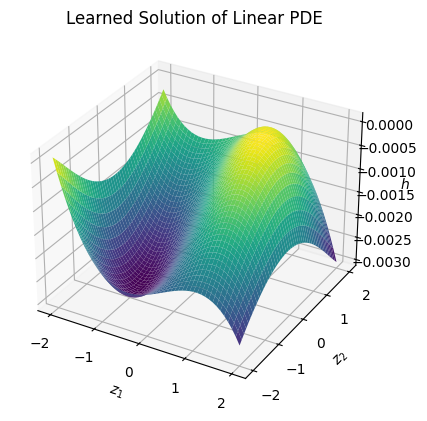

In [ ]:
#Plot learned solution h^*

fig = plt.figure()
ax = plt.axes(projection='3d')
X,Y = jnp.meshgrid(x_grid,y_grid)
ax.plot_surface(X,Y,h_approx+v1[0]*X+v1[1]*Y,cmap='viridis')
ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2$')
ax.set_zlabel(r'$h$')
ax.zaxis.labelpad=-0.7 # <- change the value here
ax.set_title('Learned Solution of Linear PDE')

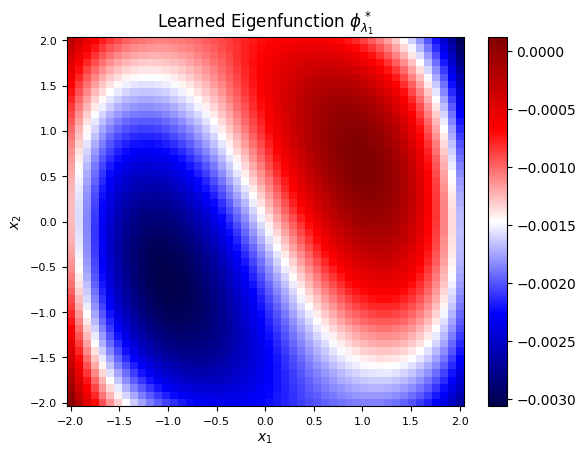

In [ ]:
fig = plt.figure()
X,Y = jnp.meshgrid(x_grid,y_grid)
plt.pcolormesh(X,Y,h_approx+v1[0]*X+v1[1]*Y, cmap='seismic')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Learned Eigenfunction $\phi^*_{\lambda_1}$')
# plt.title('lambda = '+ str(0.78),fontsize=20)
plt.colorbar()
# plt.savefig("duffing.png")
# files.download("duffing.png")
plt.show()

NameError: name 'h_true' is not defined

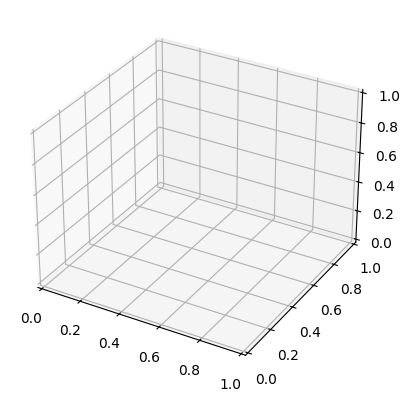

In [ ]:
#L2 relative error
fig = plt.figure()
ax = plt.axes(projection='3d')
X,Y = jnp.meshgrid(x_grid,y_grid)
ax.plot_surface(X,Y,jnp.abs(h_true-h_approx)/(jnp.abs(h_true)),cmap='viridis')
#plt.title('Solution of Linear PDE')
ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2$')
ax.set_zlabel('Error',rotation=270)
ax.set_title('Relative Error of PDE')
ax.zaxis.labelpad=0.7